In [0]:
#importing secter keys for kaggle


In [38]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

 99% 2.35G/2.37G [00:17<00:00, 156MB/s]
100% 2.37G/2.37G [00:17<00:00, 148MB/s]


In [40]:
!unzip weed-detection-in-soybean-crops.zip

Archive:  weed-detection-in-soybean-crops.zip
replace dataset/broadleaf/1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!rm weed-detection-in-soybean-crops.zip

##Data Analysis

In [42]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import glob

%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
data_dir = r'dataset/dataset/'

In [14]:
num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

print(all_files[0])
    
# Image dimension
im_width = 230
im_height = 230 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.uint8)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.uint8)
X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)
X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.uint8)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200) 

for i, cls in enumerate(classes): 
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i
    
del Y 
del X

dataset/dataset/broadleaf/255.tif


In [0]:
num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

In [0]:
im_width = 230
im_height = 230 
im_channel = 3

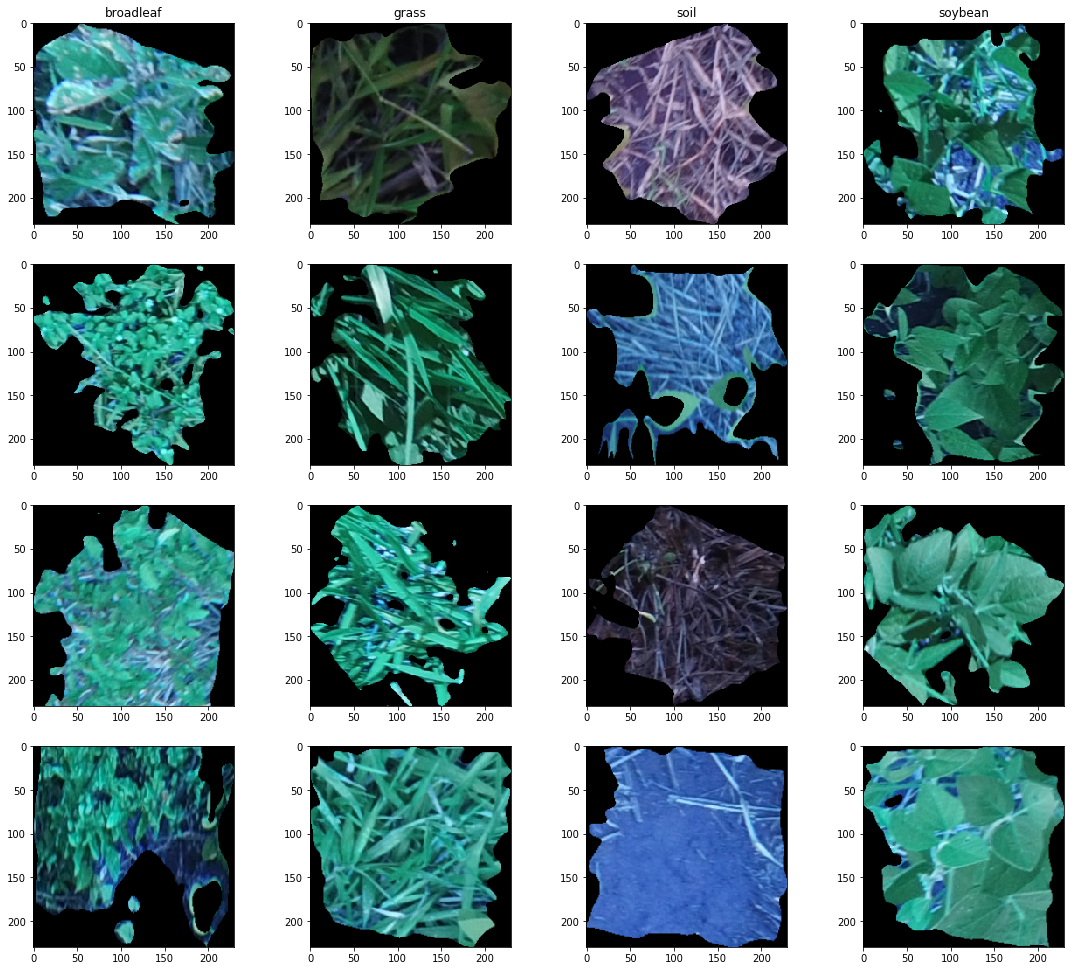

In [45]:
# Visualize some images 
# Make sure that everything when OK
num_file = 1100 
n_class = len(classes)
samples_per_class = 4


for y, cls in enumerate(classes):
    all_files = [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    for idx in range(samples_per_class):
        plt_idx = idx * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        img = cv2.resize(cv2.imread(all_files[idx]), (im_width, im_height))
        plt.imshow(img.reshape(im_width, im_height, im_channel).astype('uint8'))
        if(idx==0): plt.title(cls)

plt.show()

#Dataset Preparation

In [0]:
from sklearn.model_selection import train_test_split
from shutil import copyfile, move

In [0]:
folders = ['train', 'test']
for folder in folders:
    if not os.path.exists("dataset/{}".format(folder)):
        os.makedirs("dataset/{}".format(folder))
    for cls in classes:
      if not os.path.exists("dataset/{}/{}".format(folder,cls)):
        os.makedirs("dataset/{}/{}".format(folder,cls))

In [0]:
for cls in classes:
  if os.path.exists("dataset/{}".format(cls)):
    path = "dataset/{}".format(cls)
    files = os.listdir(path)
    x_train ,x_test = train_test_split(files,test_size=0.5)

    for file in x_train:
      move('dataset/{}/{}'.format(cls,file), 'dataset/train/{}/{}'.format(cls,file))
    for file in x_test:
      move('dataset/{}/{}'.format(cls,file), 'dataset/test/{}/{}'.format(cls,file))

    !rm -rf path


##Model building


In [0]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks

In [0]:
batch_size = 64
train_data_path = 'dataset/train'
test_data_path = 'dataset/test'

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(im_height, im_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 7667 images belonging to 4 classes.


In [57]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode ="same", input_shape=(im_width, im_height, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 4, 4, border_mode ="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th'))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(230, 230,..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [59]:
lr = 0.0004
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])

In [0]:
samples_per_epoch = 400
epochs = 20

In [64]:
model.fit_generator(
    train_generator,
    samples_per_epoch=samples_per_epoch,
    epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=20, steps_per_epoch=6)`
  after removing the cwd from sys.path.




Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 7.1981 - acc: 0.4453
Epoch 2/20
6/6 [==============================] - 5s 895ms/step - loss: 8.3048 - acc: 0.4848
Epoch 3/20
6/6 [==============================] - 6s 965ms/step - loss: 8.1618 - acc: 0.4688
Epoch 4/20
6/6 [==============================] - 6s 976ms/step - loss: 8.5208 - acc: 0.4714
Epoch 5/20
6/6 [==============================] - 6s 974ms/step - loss: 8.8032 - acc: 0.3750
Epoch 6/20
6/6 [==============================] - 6s 967ms/step - loss: 1.7285 - acc: 0.5417
Epoch 7/20
6/6 [==============================] - 6s 992ms/step - loss: 0.6561 - acc: 0.7422
Epoch 8/20
6/6 [==============================] - 6s 968ms/step - loss: 0.7303 - acc: 0.7214
Epoch 9/20
6/6 [==============================] - 6s 972ms/step - loss: 0.6425 - acc: 0.7422
Epoch 10/20
6/6 [==============================] - 6s 982ms/step - loss: 0.6289 - acc: 0.7292
Epoch 11/20
6/6 [==============================] - 6s 964ms/step - los

In [0]:
model.save('model.h5')

#Model Testing

In [0]:
import random
from keras.models import Sequential, load_model
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
model_path = 'model.h5'
model = load_model(model_path)

In [104]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(im_height, im_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 7669 images belonging to 4 classes.


In [0]:
probabilities = model.predict_generator(test_generator)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = np.argmax(probabilities, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
report = classification_report(test_generator.classes, y_pred)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0: tp = 1
if tn == 0: tn = 1
if fp == 0: fp = 1
if fn == 0: fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt((float(tp)+float(fp))
    * (float(tp)+float(fn)) * (float(tn)+float(fp)) * (float(tn)+float(fn)) ), 3)

output = "results.txt"

f_output = open(output, 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch_cnn\n'.format(epochs, batch_size))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [129]:
!cat results.txt

20epochs_64batch_cnn
TN: 43
FN: 128
TP: 643
FP: 210
TPR: 0.833981841763943
FPR: 0.8300395256916996
accuracy: 0.67
specitivity: 0.17
sensitivity : 0.834
mcc : 0.005
              precision    recall  f1-score   support

           0       0.08      0.07      0.08       596
           1       0.23      0.37      0.28      1760
           2       0.21      0.22      0.22      1625
           3       0.48      0.35      0.40      3688

    accuracy                           0.30      7669
   macro avg       0.25      0.25      0.24      7669
weighted avg       0.34      0.30      0.31      7669


Sample random prediction

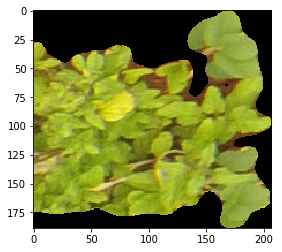

Prediction: broadleaf Real: broadleaf


In [130]:
cls = classes[random.randrange(len(classes))]
if os.path.exists("dataset/test/{}".format(cls)):
  path = "dataset/test/{}".format(cls)
  files = os.listdir(path)
  file = files[random.randrange(len(files))]
  filename = "dataset/test/{}/{}".format(cls, file)
  #print(filename, cls)
  img=mpimg.imread(filename)
  imgplot = plt.imshow(img)
  plt.show()
  x = load_img(filename, target_size=(im_width,im_height))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = model.predict(x)
  result = array[0]
#   print(result)
  answer = np.argmax(result)
  result = classes[answer]
  print('Prediction: {} Real: {}'.format(result, cls))
  
  #predict(file, cls)


In [0]:
#!rm -rf dataset